In [1]:
#ライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt

### 誤り近傍法(False Nearest Neighbor)
埋め込み次元の目安を推定する手法

In [ ]:
#x:時系列，t:時間遅れ，M:埋め込み次元(ただし変数)

def FNN(x,t,m):
  #時系列の長さ（データ点数）
  N = len(x)

  #誤り近傍法の指標を入れる配列
  E1 = []
  #指標算出のための配列
  E = []

  #再構成ベクトル
  X = np.zeros((N-t,2))
  #距離を入れる配列
  d1 = []


  #埋め込み次元が２の時のケースを先に処理
  X[:,0] = x[0:N-t]
  X[:,1] = x[t:N]
  n = len(X)

  for j in range(n):
    dist1 = np.zeros(n)

    #任意の状態空間の点同士の距離を全て算出
    dist1[:] = np.linalg.norm(X[j,:]-X[:,:],axis=1)

    #求めた距離をソート
    d1.append(np.sort(dist1)[1])




  #埋め込み次元が３以上の時の処理
  for i in range(1,m+1):

    #埋め込むためのデータ数が不足した場合終了
    if N-(i+1)*t<=0:
      return E1

    #再構成ベクトル
    X2 = np.zeros((N-(i+1)*t,i+2))
    #距離を入れる配列
    d2 = []

    n = len(X2)

    for j in range(i+2):
      X2[:,j] = x[j*t:j*t+N-(i+1)*t]

    for j in range(n):
      dist1 = np.zeros(n)
      #任意の状態空間の点同士の距離を全て算出
      dist1 = np.linalg.norm(X2[j,:]-X2[:,:],axis=1)

      #求めた距離をソート
      d2.append(np.sort(dist1)[1])


    #1つ低い次元の距離で割った値
    a = np.array(d2)[:]/np.array(d1)[:len(d2)]
    #対象の次元における1つ低い次元との比較について平均を算出
    E.append(np.mean(a))

    #1つ高い次元との比較のためにd1を更新
    d1 = np.copy(d2)


  for i in range(m-1):
    #求めた1つ低い次元との比較の平均をさらに1つ異なる次元の値と比較
    E1.append(E[i+1]/E[i])
    if np.isnan(E1[-1]):
      E1[-1] = 0


  M = np.arange(2,m+1)
  plt.plot(M,E1)
  plt.xlabel("Dimension",fontsize=14)
  plt.grid()
  return E1

In [ ]:
p = 10
r = 28
b = 8/3

def f1(x,y):
  return -p*x+p*y
def f2(x,y,z):
  return -x*z+r*x-y
def f3(x,y,z):
  return x*y-b*z

dt = 0.01
x = 0.2
y = 0.3
z = 0.4
X = []
Y = []
Z = []

for i in range(5000):
  X.append(x)
  Y.append(y)
  Z.append(z)
  k1x = f1(x,y)*dt
  k1y = f2(x,y,z)*dt
  k1z = f3(x,y,z)*dt

  k2x = f1(x+0.5*k1x,y+0.5*k1y)*dt
  k2y = f2(x+0.5*k1x,y+0.5*k1y,z+0.5*k1z)*dt
  k2z = f3(x+0.5*k1x,y+0.5*k1y,z+0.5*k1z)*dt

  k3x = f1(x+0.5*k2x,y+0.5*k2y)*dt
  k3y = f2(x+0.5*k2x,y+0.5*k2y,z+0.5*k2z)*dt
  k3z = f3(x+0.5*k2x,y+0.5*k2y,z+0.5*k2z)*dt

  k4x = f1(x+k3x,y+k3y)*dt
  k4y = f2(x+k3x,y+k3y,z+k3z)*dt
  k4z = f3(x+k3x,y+k3y,z+k3z)*dt

  x += (k1x+2*k2x+2*k3x+k4x)/6
  y += (k1y+2*k2y+2*k3y+k4y)/6
  z += (k1z+2*k2z+2*k3z+k4z)/6

FNN(Y,7,7)

### 並進誤差

Text(0.5, 0, 'z')

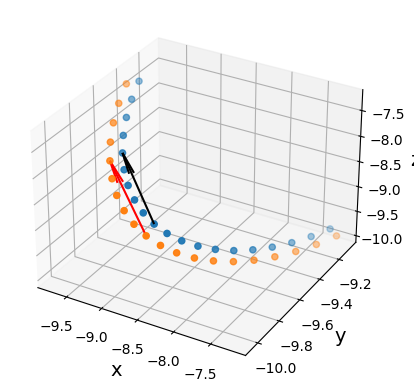

In [ ]:
#ローレンツ方程式Xの軌道並行度
from mpl_toolkits.mplot3d import Axes3D
tau = 14

#パラメータ
p = 10
r = 28
b = 8/3

def f1(x,y):
  return -p*x+p*y
def f2(x,y,z):
  return -x*z+r*x-y
def f3(x,y,z):
  return x*y-b*z

dt = 0.01
x = 0.2
y = 0.3
z = 0.4
X = []
Y = []
Z = []

for i in range(5000):
  X.append(x)
  Y.append(y)
  Z.append(z)
  k1x = f1(x,y)*dt
  k1y = f2(x,y,z)*dt
  k1z = f3(x,y,z)*dt

  k2x = f1(x+0.5*k1x,y+0.5*k1y)*dt
  k2y = f2(x+0.5*k1x,y+0.5*k1y,z+0.5*k1z)*dt
  k2z = f3(x+0.5*k1x,y+0.5*k1y,z+0.5*k1z)*dt

  k3x = f1(x+0.5*k2x,y+0.5*k2y)*dt
  k3y = f2(x+0.5*k2x,y+0.5*k2y,z+0.5*k2z)*dt
  k3z = f3(x+0.5*k2x,y+0.5*k2y,z+0.5*k2z)*dt

  k4x = f1(x+k3x,y+k3y)*dt
  k4y = f2(x+k3x,y+k3y,z+k3z)*dt
  k4z = f3(x+k3x,y+k3y,z+k3z)*dt

  x += (k1x+2*k2x+2*k3x+k4x)/6
  y += (k1y+2*k2y+2*k3y+k4y)/6
  z += (k1z+2*k2z+2*k3z+k4z)/6



#任意の点
t = 400

#２点の間隔
stp = 5

#前半3000点までを抽出
X = X[:3000]
XX = np.zeros((len(X)-3*tau,3))

#埋め込み
for i in range(3):
  XX[:,i] = X[i*tau:i*tau+len(X)-3*tau]


#距離
dist = []
for i in range(len(XX)):
  dist.append(np.linalg.norm(XX[i,:]-XX[t,:]))

#近傍のインデックス
nind = np.argsort(dist)[2]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#点t付近の軌道
ax.scatter(XX[t-10:t+10,0],XX[t-10:t+10,1],XX[t-10:t+10,2])
#近傍点付近の軌道
ax.scatter(XX[nind-10:nind+10,0],XX[nind-10:nind+10,1],XX[nind-10:nind+10,2])
#点tのstp数先の点と点tを結んだベクトル
ax.quiver3D(XX[t,0],XX[t,1],XX[t,2],XX[t+stp,0]-XX[t,0],XX[t+stp,1]-XX[t,1],XX[t+stp,2]-XX[t,2],color="k")
#近傍点のstp数先の点と近傍点を結んだベクトル
ax.quiver3D(XX[nind,0],XX[nind,1],XX[nind,2],XX[nind+stp,0]-XX[nind,0],XX[nind+stp,1]-XX[nind,1],XX[nind+stp,2]-XX[nind,2],color="r")

ax.set_xlabel("x",fontsize=14)
ax.set_ylabel("y",fontsize=14)
ax.set_zlabel("z",fontsize=14)

Text(0.5, 0, 'z')

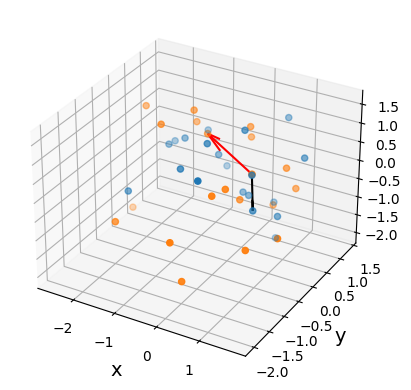

In [ ]:
#乱数列の軌道並行度
import numpy as np

#任意の点
t = 400

#２点の間隔
stp = 5

#前半3000点までを抽出
X = np.random.randn(3000)
XX = np.zeros((len(X)-3*tau,3))

#埋め込み
for i in range(3):
  XX[:,i] = X[i*tau:i*tau+len(X)-3*tau]


#距離
dist = []
for i in range(len(XX)):
  dist.append(np.linalg.norm(XX[i,:]-XX[t,:]))

#近傍のインデックス
nind = np.argsort(dist)[2]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#点t付近の軌道
ax.scatter(XX[t-10:t+10,0],XX[t-10:t+10,1],XX[t-10:t+10,2])
#近傍点付近の軌道
ax.scatter(XX[nind-10:nind+10,0],XX[nind-10:nind+10,1],XX[nind-10:nind+10,2])
#点tのstp数先の点と点tを結んだベクトル
ax.quiver3D(XX[t,0],XX[t,1],XX[t,2],XX[t+stp,0]-XX[t,0],XX[t+stp,1]-XX[t,1],XX[t+stp,2]-XX[t,2],color="k")
#近傍点のstp数先の点と近傍点を結んだベクトル
ax.quiver3D(XX[nind,0],XX[nind,1],XX[nind,2],XX[nind+stp,0]-XX[nind,0],XX[nind+stp,1]-XX[nind,1],XX[nind+stp,2]-XX[nind,2],color="r")

ax.set_xlabel("x",fontsize=14)
ax.set_ylabel("y",fontsize=14)
ax.set_zlabel("z",fontsize=14)

In [ ]:
#並進誤差
#x:時系列，t:時間遅れ，M:埋め込み次元の最大値，nn:使用する状態空間上の近傍点数，stp:並進誤差算出次のステップ数
#Q:並進誤差算出次のサンプリングする状態空間上の点数，A:並進誤差算出処理の回数

def TransErr(x,t,M,nn,stp,Q,A):
  #時系列の長さ（データ点数）
  N = len(x)
  #各埋め込み次元ごとに算出される最終値を格納する配列
  TE = []

  #埋め込み次元Mまでのアトラクタ再構成
  for m in range(1,M+1):
    X = np.zeros((N-(m-1)*t,m))
    for i in range(1,m+1):
      X[:,i-1] = x[(i-1)*t:i*t+N-m*t]

    #並進誤差A回分を格納する配列
    E = np.zeros(A)
    for a in range(A):

      #サンプリング数ごとに算出される値を格納する配列
      e = np.zeros(Q)
      #eに格納するためのインデックス
      j = 0

      sample = np.random.choice(len(X)-stp,Q,replace=False)
      for i in sample:
        #データ点数を超えないように処理
        dist = np.zeros(len(X)-stp)

        #対象のデータ点と状態空間上の任意の点の距離を計算
        dist[:] = np.linalg.norm(X[i,:]-X[:len(X)-stp,:],axis=1)

        #距離の短い順にindexを取得
        di = np.argsort(dist)

        #推移ベクトル用
        v = np.zeros(nn+1)

        #対象のデータ点と近傍点nn個のstp数先の点との推移ベクトルを算出
        v = X[di[:nn+1]+stp,:]-X[di[:nn+1],:]

        #求めた推移ベクトルの平均ベクトルを算出
        v_ave = np.mean(v,axis=0)

        #それぞれデータ点と求めた平均との差分を算出
        v_var = np.sum(np.linalg.norm(v[:]-v_ave,ord=2,axis=1))

        #vをv_aveとv_varを使って算出されるスカラーに更新
        v = v_var/np.linalg.norm(v_ave,ord=2)

        #サンプリング１回で最終的に算出される値を格納
        e[j] = v/(nn+1)
        j += 1

      #サンプリング回数ごとに算出された最終値の中央値を格納
      E[a] = np.median(e)


    TE.append(np.mean(E))

  #表示するグラフの横軸である埋め込み次元
  zigen = np.arange(2,M+1)
  plt.plot(zigen,TE[1:],'-o')
  plt.xlabel("埋め込み次元",fontsize=14)
  plt.grid()
  return TE

In [ ]:
TransErr(X,14,8,5,5,100,100)

## フーリエトランスフォームサロゲート

非線形統計量として並進誤差を利用

In [ ]:
#x:時系列，t:時間遅れ，m:埋め込み次元，nn:使用する状態空間上の近傍点数，stp:並進誤差算出次のステップ数，data:作成するサロゲートデータ数
#Q:並進誤差算出次のサンプリングする状態空間上の点数，A:並進誤差算出処理の回数

def surrogate(x,t,m,nn,stp,data,Q,A=10):
  N = len(x)

  #サロゲートデータの非線形統計量保存用の配列
  Es = np.zeros(data)


  x = np.array(x)

  #時系列データのデータ点数の偶奇で分ける
  if N%2 == 0:
    n = int(N/2)
    Judge = 0
  else:
    n = int((N-1)/2 + 1)
    Judge = 1

  for d in range(data+1):
    xs = np.copy(x)

    #d=0は元データ，それ以外はサロゲートデータ
    if d != 0:

      #フーリエ変換
      xs = np.fft.fft(xs)
      #位相をランダマイズ
      xs = xs[:n] * np.exp(np.random.rand(n)*2*np.pi*1j)

      if Judge == 0:
        xs = np.append(xs,xs[::-1])
      else:
        xs = np.append(xs,xs[-2::-1])

      #逆フーリエ変換
      xs = np.real(np.fft.ifft(xs))

    #埋め込み
    X = np.zeros((N-(m-1)*t,m))
    for i in range(1,m+1):
      X[:,i-1] = xs[(i-1)*t:i*t+N-m*t]


    #並進誤差A回分を格納する配列
    E = np.zeros(A)

    #A回処理開始
    for a in range(A):

      #サンプリング数ごとに算出される値を格納する配列
      e = np.zeros(Q)
      #eに格納するためのインデックス
      j = 0

      sample = np.random.choice(len(X)-stp,Q,replace=False)
      for i in sample:

        #データ点数を超えないように処理
        dist = np.zeros(len(X)-stp)

        #対象のデータ点と状態空間上の任意の点の距離を計算
        dist[:] = np.linalg.norm(X[i,:]-X[:len(X)-stp,:],axis=1)

        #距離の短い順にindexを取得
        di = np.argsort(dist)

        #推移ベクトル用
        v = np.zeros(nn+1)

        #対象のデータ点と近傍点nn個のstp数先の点との推移ベクトルを算出
        v = X[di[:nn+1]+stp,:]-X[di[:nn+1],:]

        #求めた推移ベクトルの平均ベクトルを算出
        v_ave = np.mean(v,axis=0)

        #それぞれデータ点と求めた平均との差分を算出
        v_var = np.sum(np.linalg.norm(v[:]-v_ave,ord=2,axis=1))

        #vをv_aveとv_varを使って算出されるスカラーに更新
        v = v_var/np.linalg.norm(v_ave,ord=2)

        #サンプリング１回で最終的に算出される値を格納
        e[j] = v/(nn+1)
        j += 1

      #サンプリング回数ごとに算出された最終値の中央値を格納
      E[a] = np.median(e)


    #オリジナルデータの非線形統計量
    if d == 0:
      Eo = np.mean(E)
    #サロゲートデータの非線形統計量を配列で保存
    else:
      Es[d-1] = np.mean(E)

    print(str(d)+'回目終了')

  return Eo,Es


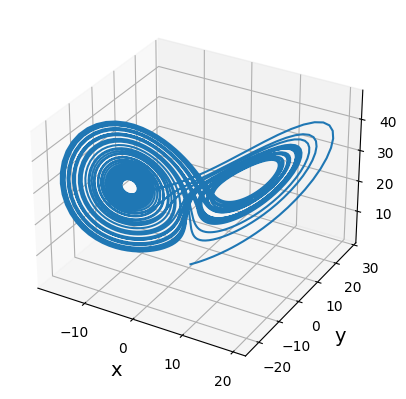

In [2]:
#Lorenz
from mpl_toolkits.mplot3d import Axes3D
p = 10
r = 28
b = 8/3

def f1(x,y):
  return -p*x+p*y
def f2(x,y,z):
  return -x*z+r*x-y
def f3(x,y,z):
  return x*y-b*z

dt = 0.01
x = 0.2
y = 0.3
z = 0.4
X = []
Y = []
Z = []

for i in range(5000):
  X.append(x)
  Y.append(y)
  Z.append(z)
  k1x = f1(x,y)*dt
  k1y = f2(x,y,z)*dt
  k1z = f3(x,y,z)*dt

  k2x = f1(x+0.5*k1x,y+0.5*k1y)*dt
  k2y = f2(x+0.5*k1x,y+0.5*k1y,z+0.5*k1z)*dt
  k2z = f3(x+0.5*k1x,y+0.5*k1y,z+0.5*k1z)*dt

  k3x = f1(x+0.5*k2x,y+0.5*k2y)*dt
  k3y = f2(x+0.5*k2x,y+0.5*k2y,z+0.5*k2z)*dt
  k3z = f3(x+0.5*k2x,y+0.5*k2y,z+0.5*k2z)*dt

  k4x = f1(x+k3x,y+k3y)*dt
  k4y = f2(x+k3x,y+k3y,z+k3z)*dt
  k4z = f3(x+k3x,y+k3y,z+k3z)*dt

  x += (k1x+2*k2x+2*k3x+k4x)/6
  y += (k1y+2*k2y+2*k3y+k4y)/6
  z += (k1z+2*k2z+2*k3z+k4z)/6

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel("x",fontsize=14)
ax.set_ylabel("y",fontsize=14)
ax.set_zlabel("z",fontsize=14)
ax.plot(X,Y,Z)
plt.show()


In [ ]:
#Lorenz方程式のYを使用

eo,es = surrogate(Y,7,3,5,12,100,100,100)
histogram = plt.hist(es,bins=100,ec='black',label="surrogate")

limit = np.max(histogram[0])+1

plt.bar(eo,height=np.max(histogram[0])+1,width=0.003,color='orange',label="original")

plt.legend()
plt.ylim(0,limit)

### ニューラルネットによる力学系の推定を用いた時系列予測
埋め込みによる再構成アトラクタを利用

In [24]:
from tensorflow.keras.layers import Input,Dense,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers

#t:時間遅れ，m:埋め込み次元
t = 14
m = 3

train_y = Y[:int(len(Y)/2)]
test_y = Y[int(len(Y)/2):]

#埋め込み
X = np.zeros((len(train_y)-m*t,m))
for i in range(m):
  X[:,i] = train_y[i*t:i*t+len(X)]

#学習データを入力と出力に分割
x_train = X[:len(X)-1,:]
y_train = X[1:len(X),:]

#tsb = TensorBoard(log_dir='./logs')
input = Input(shape=(m,))
middle1 = Dense(units=2*m,activation='sigmoid',use_bias=True)(input)
output = Dense(units=m,activation='linear')(middle1)
model = Model(inputs=[input],outputs=[output])

In [25]:
#コンパイル．最適化手法adam、損失関数は平方二乗誤差
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

Epoch 1/500
62/62 [==============================] - 1s 5ms/step - loss: 70.8954 - accuracy: 0.2382 - val_loss: 83.9730 - val_accuracy: 0.1626
Epoch 2/500
62/62 [==============================] - 0s 3ms/step - loss: 66.9368 - accuracy: 0.2219 - val_loss: 83.1477 - val_accuracy: 0.1789
Epoch 3/500
62/62 [==============================] - 0s 3ms/step - loss: 63.1708 - accuracy: 0.2142 - val_loss: 82.0050 - val_accuracy: 0.2480
Epoch 4/500
62/62 [==============================] - 0s 3ms/step - loss: 59.4934 - accuracy: 0.2153 - val_loss: 80.7817 - val_accuracy: 0.3963
Epoch 5/500
62/62 [==============================] - 0s 3ms/step - loss: 55.8686 - accuracy: 0.2219 - val_loss: 79.7363 - val_accuracy: 0.4797
Epoch 6/500
62/62 [==============================] - 0s 3ms/step - loss: 52.2607 - accuracy: 0.2555 - val_loss: 78.7871 - val_accuracy: 0.5061
Epoch 7/500
62/62 [==============================] - 0s 3ms/step - loss: 48.5717 - accuracy: 0.3634 - val_loss: 77.8920 - val_accuracy: 0.4553

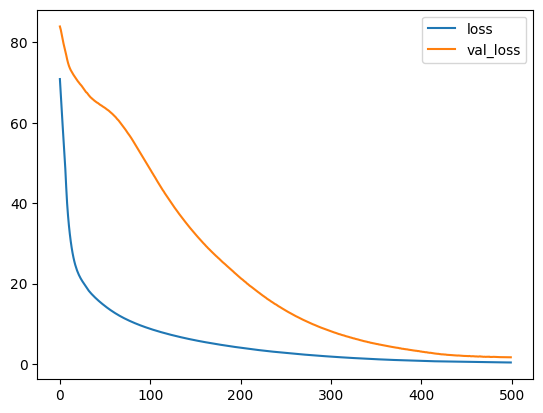

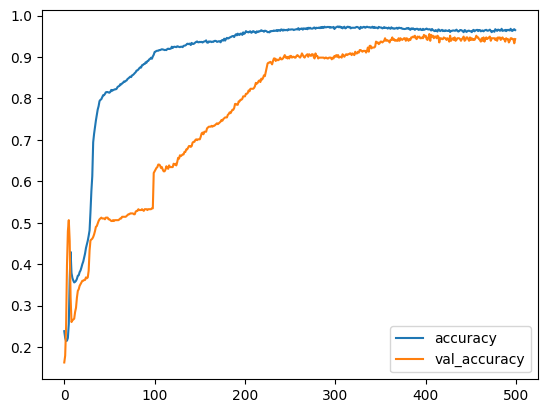

In [26]:
history = model.fit(x_train,y_train,epochs=500,validation_split=0.2)
plt.subplots()
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.subplots()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [27]:
#テストデータの埋め込み
X2 = np.zeros((len(test_y)-m*t,m))
for i in range(m):
  X2[:,i] = test_y[i*t:i*t+len(test_y)-m*t]

print(model.predict(X2))


77/77 [==============================] - 0s 1ms/step
[[0.40028858 0.7989187  3.798809  ]
 [0.26654482 0.96775913 4.108481  ]
 [0.20535135 1.154727   4.451545  ]
 ...
 [6.670416   3.0181646  6.0134187 ]
 [5.980239   3.1106987  6.3454804 ]
 [5.3753805  3.238174   6.70116   ]]


77/77 [==============================] - 0s 4ms/step


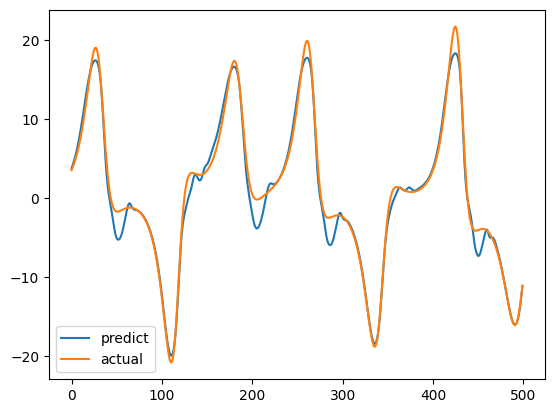

In [31]:
plt.plot(model.predict(X2)[:500,m-1],label='predict')
plt.plot(X2[1:501,m-1],label='actual')

plt.legend()